# Using LSTMs to Predict LeBron James' Points in the Next Game

**Team:** Taiyo Nakai & Jonathan Wu  
**Objective:** Train an LSTM neural network to predict LeBron James' performance (e.g., over/under betting) using historical game data.  
**Methods:** LSTM model with softmax activation for multiclass outcomes. Incorporating long-term and short-term performance trends.  
**Data Source:** Basketball Reference (https://www.basketball-reference.com/players/j/jamesle01.html); CSV files for individual player game data and BettinggPros (https://www.bettingpros.com/nba/props/lebron-james/points/) for LeBron James historical betting data.
**Evaluation:** Precision-based evaluation with every game betting simulation.  
**Experiments:** Hyperparameter tuning for LSTM architecture, dropout, and forget gate bias initialization.

## Imports

In [126]:
import os
import shutil
import random
import copy
import importlib

import numpy as np
import pandas as pd
import tensorflow.keras.layers as keras_layers
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import Counter
from sortedcontainers import SortedSet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Input,
    Dropout,
    Bidirectional,
)

import keras_tuner as kt

# Loading and Merging LeBron James Game Logs

This code loads and combines multiple CSV files containing LeBron James' game logs from a specified folder.  
1. Recursively searches for CSV files in the `GAME_LOG_FOLDER`.  
2. Adds each file path to a sorted set to maintain the ordered date.  
3. Reads and concatenates all CSV files into a single DataFrame `df`.  


In [127]:
GAME_LOG_FOLDER = "LeBron James Game Logs"

def fetch_files(DIRECTORY="LeBron James Game Logs"):
    csv_files = SortedSet()
    for dir_, _, files in os.walk(DIRECTORY):
        for file_name in files:
            rel_dir = os.path.relpath(dir_, DIRECTORY)
            rel_file = os.path.join(DIRECTORY, file_name)
            csv_files.add(rel_file)

    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
    return df
    
df_uncleaned = fetch_files()
df_uncleaned

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,10/29/2003,18-303,CLE,@,SAC,L (-14),1,42:50:00,...,4,6,9,4,0,2,3,25,24.7,-9
1,2,2.0,10/30/2003,18-304,CLE,@,PHO,L (-9),1,40:21:00,...,10,12,8,1,0,7,1,21,14.7,-3
2,3,3.0,11/1/2003,18-306,CLE,@,POR,L (-19),1,39:10:00,...,4,4,6,2,0,2,3,8,5,-21
3,4,4.0,11/5/2003,18-310,CLE,NaN,DEN,L (-4),1,41:06:00,...,9,11,7,2,3,2,1,7,11.2,-3
4,5,5.0,11/7/2003,18-312,CLE,@,IND,L (-1),1,43:44:00,...,5,5,3,0,0,7,2,23,9,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,78,78.0,4/6/2025,40-098,LAL,@,OKC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1763,79,79.0,4/8/2025,40-100,LAL,@,OKC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1764,80,80.0,4/9/2025,40-101,LAL,@,DAL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1765,81,81.0,4/11/2025,40-103,LAL,NaN,HOU,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN


# Renaming Columns in Game Log Data

This code renames two in the game log DataFrame for better readability.  

1. Renames the columns `'Unnamed: 5'` and `'Unnamed: 7'` to `'Location'` and `'Score Differential'`, respectively.  


In [128]:
def df_rename(df):
    df = df.rename(columns={'Unnamed: 5': 'Location', 'Unnamed: 7': 'Score Differential'})
    return df

df_renamed = df_rename(df_uncleaned.copy())
df_renamed.columns.values

array(['Rk', 'G', 'Date', 'Age', 'Tm', 'Location', 'Opp',
       'Score Differential', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-'], dtype=object)

# Data Cleaning & Feature Engineering

This code performs several data preprocessing steps on the game log DataFrame to clean.  
1. Drops rows where the `'G'` (Game) column is NaN.  
2. Converts the `'Date'` column to datetime format, and extracts the day, month, and year into new columns.  
3. Drops irrelevant columns like `'Rk'`, `'G'`, `'Date'`, etc.  
4. Maps categorical values in the `'Location'` column (home or away) and updates `'Opp'` and `'Tm'` columns to numeric values representing teams.  
5. Converts the `'MP'` column (minutes played) into a float, representing total minutes played in decimal format.  
6. Calculates and updates the `'Age'` column by converting it from a year-day format to a float representing age in years. 
7. Converts all columns to `float` type for consistency.  
8. If `betting_lines` is enabled, drop additional columns.

In [129]:
def cleansing(df, betting_lines=False):
    df.drop(df.index[df['G'].isnull()], inplace = True)

    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    df = df.drop(columns=['Rk', 'G', 'Date', 'Score Differential', 'GS', 'GmSc', '+/-', 'ORB', 'DRB', 'TRB', 
                          'AST', 'STL', 'BLK', 'TOV', 'PF', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
                          '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
                          'BLK', 'TOV', 'PF'])

    df['Location'] = df['Location'].map({'@': 1, np.nan: 0}) 

    df['Opp'] = df['Opp'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                               'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                               'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                               'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                               'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                               'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31}) 

    df['Tm'] = df['Tm'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                             'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                             'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                             'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                             'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                             'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31})

    for i, row in df.iterrows():
        year, days = df.loc[i]['Age'].split('-')
        if int(df.loc[i]['Year']) % 4 == 0:
            days = int(days) / 366
        else:
            days = int(days) / 365
        df.loc[i, 'Age'] = int(year) + days
    
    if betting_lines:
        df = df[(df['Line'] != 'Inactive') & (df['Line'].notna())]
        df = df[(df['PTS'] != -1)]
        df = df.drop(columns=['Age', 'Tm', 'Location', 'Opp'])

    df = df.astype(float)
    return df

df_cleaned = cleansing(df_renamed.copy())
df_cleaned

,Age,Tm,Location,Opp,PTS,Day,Month,Year
0,18.830137,6.0,1.0,26.0,25.0,29.0,10.0,2003.0
1,18.832877,6.0,1.0,24.0,21.0,30.0,10.0,2003.0
2,18.838356,6.0,1.0,25.0,8.0,1.0,11.0,2003.0
3,18.849315,6.0,0.0,8.0,7.0,5.0,11.0,2003.0
4,18.854795,6.0,1.0,12.0,23.0,7.0,11.0,2003.0
...,...,...,...,...,...,...,...,...
1762,40.268493,14.0,1.0,21.0,-1.0,6.0,4.0,2025.0
1763,40.273973,14.0,1.0,21.0,-1.0,8.0,4.0,2025.0
1764,40.276712,14.0,1.0,7.0,-1.0,9.0,4.0,2025.0
1765,40.282192,14.0,0.0,11.0,-1.0,11.0,4.0,2025.0


# Data Scaling and Splitting for Time-Series Model

This code scales the features and target variable, and prepares the data for training a time-series model using sliding windows.   
1. **Scaling:**  
   - Scales the feature columns (excluding `'PTS'`) using `MinMaxScaler`.  
   - Scales the target column `'PTS'` using the same scaler.  
2. **Data Splitting:**  
   - Defines a `split()` function that creates sequences of past data points (with a specified window length) to predict future values.  
3. **Train/Test Split:**  
   - Splits the scaled features into training (80%) and testing (20%) sets.  
4. **Windowing:**  
   - Applies the `split()` function to create input-output pairs for training and testing using a variable sliding window length.  
5. **Reshaping:**  
   - Reshapes the input data into 3D arrays suitable for feeding into a neural network (samples, time steps, features).  
  

In [130]:
WINDOW = 5
YEAR_LIMIT = 2022

def split_train_test(df, window, year_limit):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df.drop(columns=['PTS']))
    scaled_target = scaler.fit_transform(df[['PTS']])

    def split(dataset, window=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-window-1):
            a = dataset[i:(i+window), 0]
            dataX.append(a)
            dataY.append(dataset[i + window, 0])
        return np.array(dataX), np.array(dataY)

    train_size = df[(df['Year'] < year_limit) | ((df['Year'] == year_limit) & (df['Month'] < 7))].shape[0]
    test_size = len(scaled_target) - train_size
    train, test = scaled_features[0:train_size,:], scaled_target[train_size:len(scaled_target),:]

    trainX, trainY = split(train, window)
    testX, testY = split(test, window)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX, trainY, testY, scaler

trainX, testX, trainY, testY, scaler = split_train_test(df_cleaned.copy(), WINDOW, YEAR_LIMIT)

# Building and Training the LSTM Model

This code defines, compiles, and trains a LSTM model for predicting LeBron James' performance.  
1. **Model Architecture:**  
   - Creates a sequential model with the layers shown below
2. **Compilation:**  
   - Compiles the model using the Adam optimizer, mean squared error (MSE) loss, and mean absolute error (MAE) metric.  
3. **Callbacks:**  
   - Implements early stopping based on validation MAE with a patience of 10 epochs.  
4. **Training:**  
   - Trains the model for up to 50 epochs, using a batch size of 32, with validation data and the early stopping callback.  
5. **Output:** The model's training history is stored in `LSTM_History`.


In [131]:
def build_LSTM():
    LSTM = getattr(layers, 'LSTM') # DO NOT REMOVE; this line allows for this function to be rerun without restarting
    LSTM_Model = Sequential([
        Input(shape=(trainX.shape[1], trainX.shape[2])),
        Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001))),
        LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.25),
        LSTM(units=64,return_sequences=True),
        Dropout(0.25),
        LSTM(units=32,return_sequences=True),
        Dropout(0.25),
        LSTM(units=32),
        Dropout(0.25),
        Dense(32, kernel_regularizer=l2(0.001)),
        Dense(1, kernel_regularizer=l2(0.001), bias_initializer='zeros')
    ])

    LSTM_Model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)
    ]

    LSTM_History = LSTM_Model.fit(
        trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), callbacks=callbacks
    )

    return LSTM_Model, LSTM_History

LSTM, _ = build_LSTM()

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.4454 - mae: 0.3191 - val_loss: 0.1586 - val_mae: 0.1939
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1254 - mae: 0.1954 - val_loss: 0.0636 - val_mae: 0.1349
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0419 - mae: 0.0701 - val_loss: 0.0413 - val_mae: 0.1123
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - mae: 0.0537 - val_loss: 0.0345 - val_mae: 0.1045
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0221 - mae: 0.0488 - val_loss: 0.0308 - val_mae: 0.1016
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - mae: 0.0427 - val_loss: 0.0275 - val_mae: 0.0979
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - mae: 0.0396 - val_loss: 0.0258 - val_mae: 0.0918
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mae: 0.0405 - val_loss: 0.0238 - val_mae: 0.0884
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mae:

# LSTM Prediction with Recurrent Updates  

This code defines a function `LSTM_Predict` that generates predictions for LeBron James' performance using a trained LSTM model. The function recursively predicts outcomes while updating test data and incorporating realistic noise into predictions.

### **Key Components**

1. **Function Purpose:**  
   - Recursively generates predictions using the LSTM model and updates the DataFrame with predicted values.  

2. **Helper Functions:**  
   - **`insert_predictions_into_df(df, predictions)`**:  
     Pads predictions with leading zeros so they align with the input DataFrame.  
   - **`new_window(X_test, scaled_prediction)`**:  
     Updates the sliding windows in `X_test` with the most recent scaled prediction.  
   - **`new_target(y_test, scaled_prediction)`**:  
     Replaces the next target value (`y_test`) with the scaled prediction.  
   - **`predict_with_noise(prediction, last_game_pts)`**:  
     Adds Gaussian noise to predictions, adjusting based on historical statistics to simulate realistic variation.  

3. **Core Logic: Recursive Predictions**  
   - **`recurrent_predictions(X_test, y_test, current_length)`**:  
     - Recursively predicts future values, updating test data and inserting predictions into the DataFrame.  
     - The loop runs until all test data is exhausted.  
     - Steps include:  
       1. Generating LSTM predictions.  
       2. Adding noise to predictions.  
       3. Updating the test input (`X_test`) and target values (`y_test`) with the most recent predictions.  

4. **Execution Flow:**  
   - The function starts predicting at the most recent game (where actual points are unknown).  
   - Updates the `PTS` column in the input DataFrame (`df`) with predictions.  
   - Inserts the final predictions into a new DataFrame.  

5. **Output:**  
   - Returns the updated DataFrame (`df_prediction`), the list of predictions, actual target values, and the index of the most recent game.  


In [132]:
def LSTM_Predict(model, df, X_test, y_test, year_limit, window, early_break=False):
    def insert_predictions_into_df(df, predictions):
        "Pads the prediction array with enough 0s to be put into the dataframe"
        diff = len(df) - len(predictions)
        padded_predictions = [0] * diff + predictions
        df["Predicted"] = padded_predictions
        return df
    
    def new_window(X_test, scaled_prediction, window_size):
        """
        Updates the windows in the test data (X_test) by replacing the first occurrence of 0 
        with the scaled prediction value at the appropriate index.
        """
        replacement_index = window_size-1
        for _ in X_test:
            for window in _:
                if 0 in window and replacement_index >= 0:
                    window[replacement_index] = scaled_prediction.item()
                    replacement_index -= 1
                elif replacement_index < 0:
                    break

    def new_target(y_test, scaled_prediction):
        """
        Updates the target values (y_test) by replacing the first occurrence of 0 with the 
        scaled prediction value.
        """
        index = np.where(y_test == 0)[0][0]
        y_test[index] = scaled_prediction.item()

    def predict_with_noise(prediction, last_game_pts):
        """
        Adds noise to the given prediction by drawing from a normal distribution based on 
        historical data statistics (mean and std of 'PTS'). The noisy prediction is adjusted 
        depending on whether the noise is greater than the original prediction.
        """
        stats = df[(df['Year'] < year_limit) | ((df['Year'] == year_limit) & (df['Month'] < 7))]['PTS'].describe()
        gaussian = np.random.normal(stats['mean'], stats['std'], size=1)
        if gaussian > prediction:
            return np.round((gaussian + prediction) / 1.75, 0)
        else:
            return np.round((gaussian + prediction) / 2.8, 0)

        
    def recurrent_predictions(X_test, y_test, current_length):
        """
        Makes recursive predictions using the LSTM model, updating the 'PTS' column in the 
        DataFrame with noisy predictions at each step. The process continues until all test 
        data is used.
        """
        n = len(X_test)
        temp_df = df.copy()
        counter = current_length
        while counter < n:
            current_X, current_y = X_test[:counter], y_test[:counter]
            predictions = model.predict(np.array(current_X))
            predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
            predictions = [round(points[0]) for points in predictions]
            actual = scaler.inverse_transform(np.array(current_y).reshape(-1, 1))
            
            if early_break and counter - current_length == 2:
                return temp_df, predictions, actual
            
            index = temp_df[temp_df['PTS'] == -1].index[0]
            temp_df.loc[index, 'PTS'] = predict_with_noise(predictions[-1], predictions[-2])
            
            if current_length == n:
                break
            
            temp_scaling = scaler.fit_transform(temp_df[['PTS']])
            scaled_index = temp_scaling.tolist().index([0])-1
            scaled_number = temp_scaling[scaled_index]

            new_window(X_test, scaled_number, window)
            new_target(y_test, scaled_number)

            counter += 1
        return temp_df, predictions, actual

    recent_game = testY.tolist().index(0)
    temp_df, predictions, actual = recurrent_predictions(copy.deepcopy(testX), copy.deepcopy(testY), recent_game)
    temp_df = insert_predictions_into_df(temp_df, predictions)
    return temp_df, predictions, actual, recent_game-1

df_prediction, predictions, actual, recent_game = LSTM_Predict(LSTM, df_cleaned.copy(), testX, testY, YEAR_LIMIT, 5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━

# Plotting Actual vs. Predicted Values

This code visualizes the actual and predicted values of points scored for the test set.


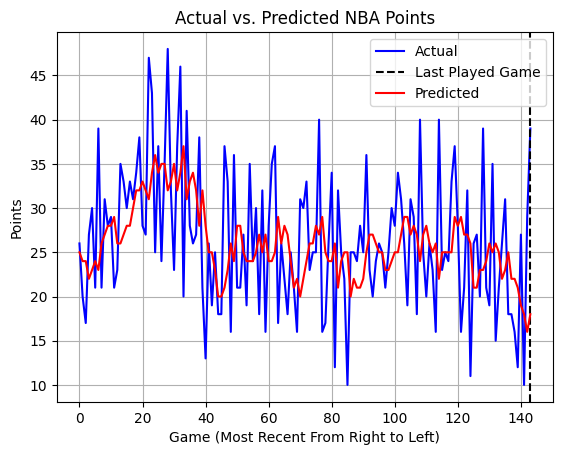

In [133]:
plt.plot(actual[:recent_game+1], label='Actual', color='blue')
plt.axvline(x=recent_game, color='black', linestyle='--', label='Last Played Game')
plt.plot(predictions[:recent_game+1], label='Predicted', color='red')

plt.title('Actual vs. Predicted NBA Points')
plt.xlabel('Game (Most Recent From Right to Left)')
plt.ylabel('Points')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

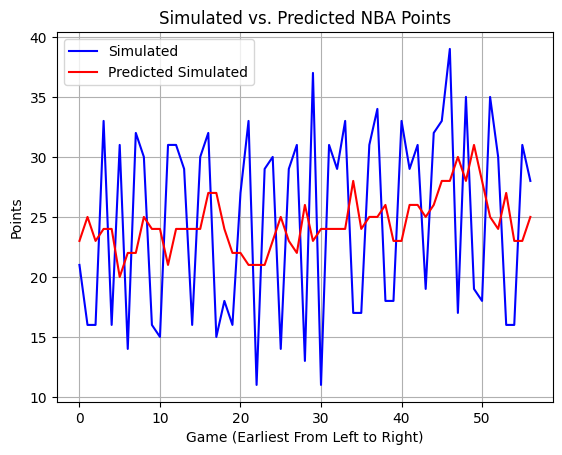

In [134]:
plt.plot(actual[recent_game+1:], label='Simulated', color='blue')
plt.plot(predictions[recent_game+1:], label='Predicted Simulated', color='red')

plt.title('Simulated vs. Predicted NBA Points')
plt.xlabel('Game (Earliest From Left to Right)')
plt.ylabel('Points')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Admittedly, any point after the first predicted point is just a simulation based on the scoring distribution of LeBron James; the central focus of the predictive LSTM model capabilities is only to be the prediction right after LeBron's most recent game.

# Testing Next Game's Score Prediction Distribution

We might want to see what prediction score distribution that the model would predict given the last 5 (real) games played by LeBron James and see if there's a general direction or pattern to what the model thinks.

Let's run 100 different trials and graph the frequency of the points predicted.

In [10]:
def get_next_game_distribution(trials=100):
    distribution = []
    for trial in range(trials):
        LSTM, _ = build_LSTM()
        _, predictions, _, recent_game = LSTM_Predict(
            LSTM, df_cleaned.copy(), testX, testY, year_limit=2022, early_break=True
        )
        distribution.append(predictions[recent_game+1])
        if trial == trials-1:
            return distribution, predictions, actual, recent_game

dist, _, _, recent_game = get_next_game_distribution()

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.4512 - mae: 0.3275 - val_loss: 0.1572 - val_mae: 0.1935
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1246 - mae: 0.1954 - val_loss: 0.0659 - val_mae: 0.1424
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0427 - mae: 0.0766 - val_loss: 0.0410 - val_mae: 0.1105
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - mae: 0.0510 - val_loss: 0.0351 - val_mae: 0.1054
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mae: 0.0512 - val_loss: 0.0314 - val_mae: 0.1015
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - mae: 0.0432 - val_loss: 0.0281 - val_mae: 0.0970
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - mae: 0.0398 - val_loss: 0.0258 - val_mae: 0.0936
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0404 - val_loss: 0.0258 - val_mae: 0.0973
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - mae:

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mae: 0.0401 - val_loss: 0.0274 - val_mae: 0.0993
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - mae: 0.0376 - val_loss: 0.0250 - val_mae: 0.0944
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mae: 0.0357 - val_loss: 0.0237 - val_mae: 0.0903
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - mae: 0.0382 - val_loss: 0.0227 - val_mae: 0.0913
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - mae: 0.0363 - val_loss: 0.0214 - val_mae: 0.0931
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - mae: 0.0375 - val_loss: 0.0207 - val_mae: 0.0877
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - mae: 0.0341 - val_loss: 0.0201 - val_mae: 0.0939
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0376 - val_loss: 0.0196 - val_mae: 0.0916
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mae: 0.0396

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - mae: 0.0392 - val_loss: 0.0202 - val_mae: 0.0863
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - mae: 0.0359 - val_loss: 0.0198 - val_mae: 0.0920
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0363 - val_loss: 0.0198 - val_mae: 0.0908
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0335 - val_loss: 0.0193 - val_mae: 0.0930
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0319 - val_loss: 0.0189 - val_mae: 0.0898
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0312 - val_loss: 0.0189 - val_mae: 0.0865
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.4542 - mae: 0.3285 - val_loss: 0.1779 - val_mae: 0.2277
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1245 - mae: 0.1977

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - mae: 0.0434 - val_loss: 0.0280 - val_mae: 0.1000
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0154 - mae: 0.0413 - val_loss: 0.0265 - val_mae: 0.0918
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0444 - val_loss: 0.0245 - val_mae: 0.0962
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - mae: 0.0430 - val_loss: 0.0236 - val_mae: 0.0955
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0346 - val_loss: 0.0231 - val_mae: 0.0937
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0350 - val_loss: 0.0211 - val_mae: 0.0879
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - mae: 0.0338 - val_loss: 0.0210 - val_mae: 0.0964
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0344 - val_loss: 0.0207 - val_mae: 0.0910
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0354

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0399 - val_loss: 0.0261 - val_mae: 0.1002
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - mae: 0.0453 - val_loss: 0.0243 - val_mae: 0.0959
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - mae: 0.0378 - val_loss: 0.0232 - val_mae: 0.0964
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - mae: 0.0374 - val_loss: 0.0223 - val_mae: 0.0953
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0348 - val_loss: 0.0212 - val_mae: 0.0908
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - mae: 0.0370 - val_loss: 0.0207 - val_mae: 0.0925
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0357 - val_loss: 0.0206 - val_mae: 0.0954
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - mae: 0.0350 - val_loss: 0.0198 - val_mae: 0.0872
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mae: 0.034

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0352 - val_loss: 0.0199 - val_mae: 0.0981
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0364 - val_loss: 0.0188 - val_mae: 0.0943
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - mae: 0.0349 - val_loss: 0.0183 - val_mae: 0.0898
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4362 - mae: 0.3075 - val_loss: 0.1655 - val_mae: 0.2039
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1267 - mae: 0.1993 - val_loss: 0.0669 - val_mae: 0.1434
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0431 - mae: 0.0758 - val_loss: 0.0413 - val_mae: 0.1105
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - mae: 0.0501 - val_loss: 0.0354 - val_mae: 0.1041
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 - mae: 0.0474 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mae: 0.0382 - val_loss: 0.0190 - val_mae: 0.0911
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0309 - val_loss: 0.0189 - val_mae: 0.0915
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4538 - mae: 0.3307 - val_loss: 0.1620 - val_mae: 0.2014
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1172 - mae: 0.1785 - val_loss: 0.0572 - val_mae: 0.1223
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0388 - mae: 0.0653 - val_loss: 0.0393 - val_mae: 0.1093
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - mae: 0.0554 - val_loss: 0.0337 - val_mae: 0.1074
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - mae: 0.0506 - val_loss: 0.0294 - val_mae: 0.0986
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mae: 0.0455 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - mae: 0.0391 - val_loss: 0.0229 - val_mae: 0.0893
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0344 - val_loss: 0.0219 - val_mae: 0.0883
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0346 - val_loss: 0.0210 - val_mae: 0.0891
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mae: 0.0338 - val_loss: 0.0212 - val_mae: 0.0926
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - mae: 0.0394 - val_loss: 0.0206 - val_mae: 0.0923
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4462 - mae: 0.3228 - val_loss: 0.1617 - val_mae: 0.2019
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1257 - mae: 0.2007 - val_loss: 0.0655 - val_mae: 0.1422
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433 - mae: 0.0830 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mae: 0.0406 - val_loss: 0.0272 - val_mae: 0.0951
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - mae: 0.0371 - val_loss: 0.0260 - val_mae: 0.0963
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - mae: 0.0410 - val_loss: 0.0236 - val_mae: 0.0906
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - mae: 0.0361 - val_loss: 0.0225 - val_mae: 0.0937
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mae: 0.0355 - val_loss: 0.0215 - val_mae: 0.0848
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - mae: 0.0377 - val_loss: 0.0207 - val_mae: 0.0887
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0353 - val_loss: 0.0202 - val_mae: 0.0893
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - mae: 0.0318 - val_loss: 0.0201 - val_mae: 0.0906
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0354

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0356 - val_loss: 0.0181 - val_mae: 0.0934
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - mae: 0.0338 - val_loss: 0.0179 - val_mae: 0.0945
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4586 - mae: 0.3394 - val_loss: 0.1627 - val_mae: 0.2034
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1238 - mae: 0.1939 - val_loss: 0.0629 - val_mae: 0.1370
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0408 - mae: 0.0705 - val_loss: 0.0407 - val_mae: 0.1133
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0271 - mae: 0.0581 - val_loss: 0.0341 - val_mae: 0.1051
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - mae: 0.0444 - val_loss: 0.0306 - val_mae: 0.1021
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - mae: 0.0473 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0386 - val_loss: 0.0255 - val_mae: 0.0934
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - mae: 0.0381 - val_loss: 0.0241 - val_mae: 0.0935
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - mae: 0.0353 - val_loss: 0.0228 - val_mae: 0.0892
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mae: 0.0359 - val_loss: 0.0219 - val_mae: 0.0911
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - mae: 0.0328 - val_loss: 0.0217 - val_mae: 0.0923
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - mae: 0.0355 - val_loss: 0.0206 - val_mae: 0.0914
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0330 - val_loss: 0.0203 - val_mae: 0.0876
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0367 - val_loss: 0.0199 - val_mae: 0.0946
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - mae: 0.034

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.4449 - mae: 0.3194 - val_loss: 0.1625 - val_mae: 0.1986
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1305 - mae: 0.2075 - val_loss: 0.0655 - val_mae: 0.1385
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433 - mae: 0.0746 - val_loss: 0.0417 - val_mae: 0.1095
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - mae: 0.0528 - val_loss: 0.0346 - val_mae: 0.1011
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mae: 0.0438 - val_loss: 0.0316 - val_mae: 0.1026
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - mae: 0.0446 - val_loss: 0.0281 - val_mae: 0.0952
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0369 - val_loss: 0.0258 - val_mae: 0.0932
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - mae: 0.0354 - val_loss: 0.0242 - val_mae: 0.0913
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - mae: 0.0342 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0328 - val_loss: 0.0191 - val_mae: 0.0897
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0334 - val_loss: 0.0187 - val_mae: 0.0880
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - mae: 0.0326 - val_loss: 0.0188 - val_mae: 0.0927
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - mae: 0.0346 - val_loss: 0.0182 - val_mae: 0.0861
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0388 - val_loss: 0.0181 - val_mae: 0.0908
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.0363 - val_loss: 0.0180 - val_mae: 0.0911
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0336 - val_loss: 0.0180 - val_mae: 0.0958
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mae: 0.0351 - val_loss: 0.0178 - val_mae: 0.0912
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0373 - val_loss: 0.0206 - val_mae: 0.0924
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - mae: 0.0330 - val_loss: 0.0203 - val_mae: 0.0894
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.4559 - mae: 0.3378 - val_loss: 0.1649 - val_mae: 0.2081
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1231 - mae: 0.1948 - val_loss: 0.0664 - val_mae: 0.1449
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0427 - mae: 0.0809 - val_loss: 0.0418 - val_mae: 0.1170
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - mae: 0.0599 - val_loss: 0.0352 - val_mae: 0.1078
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - mae: 0.0542 - val_loss: 0.0312 - val_mae: 0.1042
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - mae: 0.0496 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0337 - val_loss: 0.0229 - val_mae: 0.0966
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - mae: 0.0346 - val_loss: 0.0235 - val_mae: 0.0997
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - mae: 0.0403 - val_loss: 0.0206 - val_mae: 0.0913
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0329 - val_loss: 0.0200 - val_mae: 0.0892
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - mae: 0.0332 - val_loss: 0.0199 - val_mae: 0.0929
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.0332 - val_loss: 0.0194 - val_mae: 0.0859
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0334 - val_loss: 0.0196 - val_mae: 0.0985
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0337 - val_loss: 0.0195 - val_mae: 0.0954
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1297 - mae: 0.2078 - val_loss: 0.0767 - val_mae: 0.1636
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0478 - mae: 0.0935 - val_loss: 0.0423 - val_mae: 0.1152
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285 - mae: 0.0600 - val_loss: 0.0346 - val_mae: 0.1021
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - mae: 0.0425 - val_loss: 0.0311 - val_mae: 0.0991
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - mae: 0.0432 - val_loss: 0.0278 - val_mae: 0.0963
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - mae: 0.0422 - val_loss: 0.0257 - val_mae: 0.0958
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - mae: 0.0365 - val_loss: 0.0247 - val_mae: 0.0984
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - mae: 0.0360 - val_loss: 0.0227 - val_mae: 0.0905
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0392 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - mae: 0.0359 - val_loss: 0.0189 - val_mae: 0.0913
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0343 - val_loss: 0.0196 - val_mae: 0.0984
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4486 - mae: 0.3241 - val_loss: 0.1614 - val_mae: 0.2014
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1216 - mae: 0.1919 - val_loss: 0.0643 - val_mae: 0.1393
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0419 - mae: 0.0732 - val_loss: 0.0407 - val_mae: 0.1114
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283 - mae: 0.0596 - val_loss: 0.0343 - val_mae: 0.1029
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.0487 - val_loss: 0.0304 - val_mae: 0.0995
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - mae: 0.0422 - v

Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.0408 - val_loss: 0.0272 - val_mae: 0.0948
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0400 - val_loss: 0.0251 - val_mae: 0.0897
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - mae: 0.0383 - val_loss: 0.0237 - val_mae: 0.0947
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - mae: 0.0365 - val_loss: 0.0225 - val_mae: 0.0918
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.0336 - val_loss: 0.0239 - val_mae: 0.0979
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0420 - val_loss: 0.0210 - val_mae: 0.0935
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - mae: 0.0362 - val_loss: 0.0202 - val_mae: 0.0885
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - mae: 0.0369 - val_loss: 0.0206 - val_mae: 0.0908
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.4455 - mae: 0.3209 - val_loss: 0.1695 - val_mae: 0.2141
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1257 - mae: 0.2010 - val_loss: 0.0708 - val_mae: 0.1551
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0470 - mae: 0.0947 - val_loss: 0.0412 - val_mae: 0.1135
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - mae: 0.0576 - val_loss: 0.0340 - val_mae: 0.1034
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - mae: 0.0487 - val_loss: 0.0308 - val_mae: 0.1024
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mae: 0.0424 - val_loss: 0.0277 - val_mae: 0.0994
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - mae: 0.0413 - val_loss: 0.0257 - val_mae: 0.0980
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae: 0.0369 - val_loss: 0.0238 - val_mae: 0.

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - mae: 0.0369 - val_loss: 0.0234 - val_mae: 0.0972
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0361 - val_loss: 0.0218 - val_mae: 0.0905
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - mae: 0.0348 - val_loss: 0.0219 - val_mae: 0.0897
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - mae: 0.0371 - val_loss: 0.0206 - val_mae: 0.0848
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0336 - val_loss: 0.0200 - val_mae: 0.0929
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mae: 0.0381 - val_loss: 0.0203 - val_mae: 0.0935
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - mae: 0.0361 - val_loss: 0.0192 - val_mae: 0.0882
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.0352 - val_loss: 0.0193 - val_mae: 0.0879
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.4629 - mae: 0.3433 - val_loss: 0.1604 - val_mae: 0.2001
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1198 - mae: 0.1874 - val_loss: 0.0594 - val_mae: 0.1307
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389 - mae: 0.0678 - val_loss: 0.0408 - val_mae: 0.1161
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - mae: 0.0580 - val_loss: 0.0330 - val_mae: 0.1039
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - mae: 0.0471 - val_loss: 0.0304 - val_mae: 0.1011
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - mae: 0.0474 - val_loss: 0.0270 - val_mae: 0.0979
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147 - mae: 0.0410 - val_loss: 0.0251 - val_mae: 0.0953
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - mae: 0.0434 - val_loss: 0.0245 - val_mae: 0.0962
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mae: 0.0366 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - mae: 0.0412 - val_loss: 0.0257 - val_mae: 0.0939
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - mae: 0.0368 - val_loss: 0.0242 - val_mae: 0.0925
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - mae: 0.0410 - val_loss: 0.0235 - val_mae: 0.0915
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - mae: 0.0342 - val_loss: 0.0225 - val_mae: 0.0937
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0334 - val_loss: 0.0213 - val_mae: 0.0869
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - mae: 0.0367 - val_loss: 0.0211 - val_mae: 0.0933
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mae: 0.0347 - val_loss: 0.0210 - val_mae: 0.0898
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0334 - val_loss: 0.0210 - val_mae: 0.0914
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.038

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0313 - val_loss: 0.0187 - val_mae: 0.0869
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0366 - val_loss: 0.0194 - val_mae: 0.0956
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mae: 0.0343 - val_loss: 0.0184 - val_mae: 0.0908
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mae: 0.0342 - val_loss: 0.0184 - val_mae: 0.0889
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0324 - val_loss: 0.0180 - val_mae: 0.0890
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4563 - mae: 0.3290 - val_loss: 0.1645 - val_mae: 0.2040
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1216 - mae: 0.1869 - val_loss: 0.0611 - val_mae: 0.1306
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0410 - mae: 0.0688 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - mae: 0.0501 - val_loss: 0.0303 - val_mae: 0.1023
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - mae: 0.0463 - val_loss: 0.0275 - val_mae: 0.0982
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - mae: 0.0377 - val_loss: 0.0252 - val_mae: 0.0949
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.0376 - val_loss: 0.0243 - val_mae: 0.0968
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - mae: 0.0376 - val_loss: 0.0229 - val_mae: 0.0971
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.0353 - val_loss: 0.0216 - val_mae: 0.0921
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - mae: 0.0364 - val_loss: 0.0215 - val_mae: 0.0918
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mae: 0.0354 - val_loss: 0.0203 - val_mae: 0.0915
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0323 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mae: 0.0344 - val_loss: 0.0195 - val_mae: 0.0931
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.4547 - mae: 0.3358 - val_loss: 0.1642 - val_mae: 0.2062
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1259 - mae: 0.2028 - val_loss: 0.0679 - val_mae: 0.1489
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0426 - mae: 0.0791 - val_loss: 0.0406 - val_mae: 0.1134
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - mae: 0.0598 - val_loss: 0.0353 - val_mae: 0.1087
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0224 - mae: 0.0531 - val_loss: 0.0305 - val_mae: 0.1005
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - mae: 0.0449 - val_loss: 0.0279 - val_mae: 0.1013
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149 - mae: 0.0399 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0390 - val_loss: 0.0211 - val_mae: 0.0867
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - mae: 0.0335 - val_loss: 0.0205 - val_mae: 0.0900
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - mae: 0.0327 - val_loss: 0.0212 - val_mae: 0.0971
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0360 - val_loss: 0.0199 - val_mae: 0.0943
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mae: 0.0340 - val_loss: 0.0199 - val_mae: 0.0961
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0340 - val_loss: 0.0190 - val_mae: 0.0901
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.4470 - mae: 0.3234 - val_loss: 0.1624 - val_mae: 0.2021
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1256 - mae: 0.2004

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0390 - val_loss: 0.0252 - val_mae: 0.0916
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - mae: 0.0376 - val_loss: 0.0241 - val_mae: 0.0943
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mae: 0.0427 - val_loss: 0.0225 - val_mae: 0.0928
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.0320 - val_loss: 0.0224 - val_mae: 0.0917
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mae: 0.0357 - val_loss: 0.0208 - val_mae: 0.0922
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0344 - val_loss: 0.0206 - val_mae: 0.0942
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4412 - mae: 0.3147 - val_loss: 0.1626 - val_mae: 0.1989
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1274 - mae: 0.2002 -

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - mae: 0.0399 - val_loss: 0.0238 - val_mae: 0.0924
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - mae: 0.0401 - val_loss: 0.0226 - val_mae: 0.0930
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mae: 0.0357 - val_loss: 0.0221 - val_mae: 0.0933
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mae: 0.0335 - val_loss: 0.0210 - val_mae: 0.0930
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mae: 0.0342 - val_loss: 0.0204 - val_mae: 0.0899
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0345 - val_loss: 0.0198 - val_mae: 0.0890
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0371 - val_loss: 0.0196 - val_mae: 0.0857
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0385 - val_loss: 0.0193 - val_mae: 0.0873
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - mae: 0.03

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.4376 - mae: 0.3120 - val_loss: 0.1619 - val_mae: 0.1997
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1262 - mae: 0.1985 - val_loss: 0.0606 - val_mae: 0.1279
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0406 - mae: 0.0658 - val_loss: 0.0420 - val_mae: 0.1141
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - mae: 0.0542 - val_loss: 0.0349 - val_mae: 0.1006
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.0438 - val_loss: 0.0311 - val_mae: 0.0955
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 - mae: 0.0398 - val_loss: 0.0284 - val_mae: 0.0936
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - mae: 0.0373 - val_loss: 0.0269 - val_mae: 0.0987
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0139 - mae: 0.0376 - val_loss: 0.0249 - val_mae: 0.

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mae: 0.0353 - val_loss: 0.0191 - val_mae: 0.0945
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0335 - val_loss: 0.0194 - val_mae: 0.0898
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - mae: 0.0354 - val_loss: 0.0191 - val_mae: 0.0907
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mae: 0.0345 - val_loss: 0.0187 - val_mae: 0.0979
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mae: 0.0372 - val_loss: 0.0190 - val_mae: 0.0945
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mae: 0.0337 - val_loss: 0.0189 - val_mae: 0.0980
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0329 - val_loss: 0.0179 - val_mae: 0.0908
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.4473 - mae: 0.322

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - mae: 0.0391 - val_loss: 0.0253 - val_mae: 0.0950
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - mae: 0.0361 - val_loss: 0.0245 - val_mae: 0.0977
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mae: 0.0382 - val_loss: 0.0230 - val_mae: 0.0976
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - mae: 0.0410 - val_loss: 0.0215 - val_mae: 0.0919
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - mae: 0.0353 - val_loss: 0.0218 - val_mae: 0.0926
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - mae: 0.0367 - val_loss: 0.0213 - val_mae: 0.0972
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0352 - val_loss: 0.0201 - val_mae: 0.0894
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - mae: 0.0333 - val_loss: 0.0198 - val_mae: 0.0964
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.034

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1202 - mae: 0.1874 - val_loss: 0.0595 - val_mae: 0.1282
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - mae: 0.0691 - val_loss: 0.0403 - val_mae: 0.1096
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - mae: 0.0605 - val_loss: 0.0341 - val_mae: 0.1027
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mae: 0.0481 - val_loss: 0.0304 - val_mae: 0.0983
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - mae: 0.0401 - val_loss: 0.0278 - val_mae: 0.0962
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - mae: 0.0413 - val_loss: 0.0257 - val_mae: 0.0926
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - mae: 0.0368 - val_loss: 0.0250 - val_mae: 0.0980
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - mae: 0.0373 - val_loss: 0.0231 - val_mae: 0.0944
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - mae: 0.0371 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - mae: 0.0372 - val_loss: 0.0228 - val_mae: 0.0917
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0349 - val_loss: 0.0240 - val_mae: 0.0985
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - mae: 0.0379 - val_loss: 0.0216 - val_mae: 0.0922
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0374 - val_loss: 0.0205 - val_mae: 0.0867
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0320 - val_loss: 0.0200 - val_mae: 0.0881
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - mae: 0.0332 - val_loss: 0.0203 - val_mae: 0.0891
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mae: 0.0335 - val_loss: 0.0194 - val_mae: 0.0892
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - mae: 0.0313 - val_loss: 0.0191 - val_mae: 0.0874
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - mae: 0.0369 - val_loss: 0.0217 - val_mae: 0.0980
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mae: 0.0345 - val_loss: 0.0201 - val_mae: 0.0868
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0308 - val_loss: 0.0203 - val_mae: 0.0951
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mae: 0.0332 - val_loss: 0.0194 - val_mae: 0.0940
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mae: 0.0354 - val_loss: 0.0189 - val_mae: 0.0890
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0323 - val_loss: 0.0187 - val_mae: 0.0921
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0348 - val_loss: 0.0188 - val_mae: 0.0871
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.4437 - mae: 0.316

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0325 - val_loss: 0.0192 - val_mae: 0.0974
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.4596 - mae: 0.3360 - val_loss: 0.1603 - val_mae: 0.1985
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1267 - mae: 0.2019 - val_loss: 0.0613 - val_mae: 0.1331
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0397 - mae: 0.0673 - val_loss: 0.0395 - val_mae: 0.1097
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - mae: 0.0588 - val_loss: 0.0334 - val_mae: 0.1035
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - mae: 0.0463 - val_loss: 0.0307 - val_mae: 0.1003
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - mae: 0.0474 - val_loss: 0.0274 - val_mae: 0.0958
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - mae: 0.0396 - va

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0311 - val_loss: 0.0187 - val_mae: 0.0967
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mae: 0.0350 - val_loss: 0.0189 - val_mae: 0.0944
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0343 - val_loss: 0.0180 - val_mae: 0.0853
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0325 - val_loss: 0.0178 - val_mae: 0.0907
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mae: 0.0363 - val_loss: 0.0186 - val_mae: 0.0948
Epoch 26/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mae: 0.0349 - val_loss: 0.0188 - val_mae: 0.0936
Epoch 27/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mae: 0.0324 - val_loss: 0.0177 - val_mae: 0.0917
Epoch 28/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0307 - val_loss: 0.0188 - val_mae: 0.0933
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1228 - mae: 0.1901 - val_loss: 0.0591 - val_mae: 0.1281
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394 - mae: 0.0665 - val_loss: 0.0408 - val_mae: 0.1146
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0271 - mae: 0.0600 - val_loss: 0.0333 - val_mae: 0.1016
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0205 - mae: 0.0444 - val_loss: 0.0298 - val_mae: 0.1026
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mae: 0.0404 - val_loss: 0.0267 - val_mae: 0.0938
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - mae: 0.0385 - val_loss: 0.0247 - val_mae: 0.0946
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mae: 0.0452 - val_loss: 0.0234 - val_mae: 0.0933
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mae: 0.0380 - val_loss: 0.0224 - val_mae: 0.0958
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mae: 0.0351 - v

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0370 - val_loss: 0.0222 - val_mae: 0.0900
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - mae: 0.0355 - val_loss: 0.0214 - val_mae: 0.0951
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - mae: 0.0351 - val_loss: 0.0206 - val_mae: 0.0936
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0324 - val_loss: 0.0198 - val_mae: 0.0879
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - mae: 0.0350 - val_loss: 0.0196 - val_mae: 0.0863
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0350 - val_loss: 0.0202 - val_mae: 0.0887
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mae: 0.0388 - val_loss: 0.0189 - val_mae: 0.0893
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mae: 0.0294 - val_loss: 0.0192 - val_mae: 0.0965
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0

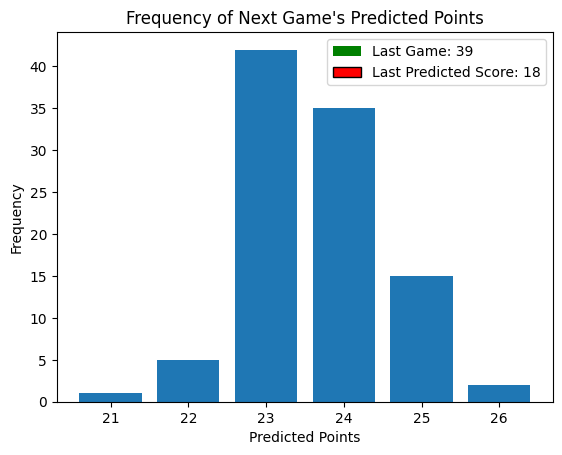

In [11]:
frequency = Counter(dist)

points = list(frequency.keys())
points_frequency = list(frequency.values())

plt.title('Frequency of Next Game\'s Predicted Points')
plt.bar(points, points_frequency)
plt.xlabel('Predicted Points')
plt.ylabel('Frequency')
plt.xticks(np.arange(min(frequency.keys()), max(frequency.keys()) + 1))
legend_elements = [
    Patch(facecolor='green', label=f"Last Game: {int(actual[recent_game].item())}"),
    Patch(facecolor='red', edgecolor='black', label=f"Last Predicted Score: {predictions[recent_game]}")
]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

As we can see, the LSTM model has a bell curve as to what it thinks LeBron James will score. As of December 8th, prior to the game today, we can see that the model shifts upward from the last predicted score. This general trend upward would likely indicate that while LeBron James will not probably score as much as 39 in today's game, he will recover from this slump from several games ago and perform better, if not average than he has recently.

Taking into consideration that the LSTM model is very conservative in its guesses because it wants to minimize the MAE, so we can hopefully predict that LeBron James to score more than what is predicted by his normal standard deviation.

# True Metric: Evaluation on Betting (Prop) Lines
While we did use MAE to best fit the model on LeBron James' historical data in points scored, we evaluted the ability of the model on a second metric: how many prop lines can it accurate hit and/or predict?

To do this, we manually scraped data from FanDuel's historical prop lines for LeBron James from 2023 to the present and compared it the actual points he scored that day, and how many points our model predicts him to actually score.

We want to maximize the amount of money earned if we were to truly bet on Lebron James.

In [182]:
WINDOW = 11
trainX, testX, trainY, testY, scaler = split_train_test(df_cleaned.copy(), WINDOW, YEAR_LIMIT)
LSTM, _ = build_LSTM()
df_prediction, predictions, actual, recent_game = LSTM_Predict(LSTM, df_cleaned.copy(), testX, testY, YEAR_LIMIT, WINDOW)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.4702 - mae: 0.3285 - val_loss: 0.1701 - val_mae: 0.2061
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1171 - mae: 0.1615 - val_loss: 0.0602 - val_mae: 0.1293
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0405 - mae: 0.0692 - val_loss: 0.0407 - val_mae: 0.1131
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0277 - mae: 0.0574 - val_loss: 0.0343 - val_mae: 0.1055
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0219 - mae: 0.0501 - val_loss: 0.0302 - val_mae: 0.1003
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mae: 0.0419 - val_loss: 0.0274 - val_mae: 0.0950
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - mae: 0.0388 - val_loss: 0.0262 - val_mae: 0.0966
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0450 - val_loss: 0.0241 - val_mae: 0.0954
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - mae:

In [183]:
BETTING_LINES_FOLDER = "LeBron James Betting Lines"
    
df_betting_uncleaned = fetch_files(BETTING_LINES_FOLDER)
df_betting_renamed = df_rename(df_betting_uncleaned.copy())
df_betting_cleaned = cleansing(df_betting_renamed.copy(), betting_lines=True)
df_betting = pd.merge(df_betting_cleaned, df_prediction[['Day', 'Month', 'Year', 'Predicted']], 
                    on=['Day', 'Month', 'Year'], how='left')

df_betting

,PTS,Line,Over,Under,Day,Month,Year,Predicted
0,21.0,23.5,-120.0,-102.0,24.0,10.0,2023.0,25
1,21.0,20.5,-118.0,-104.0,26.0,10.0,2023.0,24
2,27.0,22.5,-100.0,-122.0,29.0,10.0,2023.0,24
3,19.0,24.5,-122.0,-104.0,30.0,10.0,2023.0,24
4,35.0,22.5,-104.0,-118.0,1.0,11.0,2023.0,25
...,...,...,...,...,...,...,...,...
88,12.0,21.5,-110.0,-110.0,29.0,11.0,2024.0,25
89,27.0,24.5,-112.0,-108.0,1.0,12.0,2024.0,24
90,10.0,22.5,104.0,-128.0,2.0,12.0,2024.0,24
91,29.0,22.5,-102.0,-120.0,4.0,12.0,2024.0,21


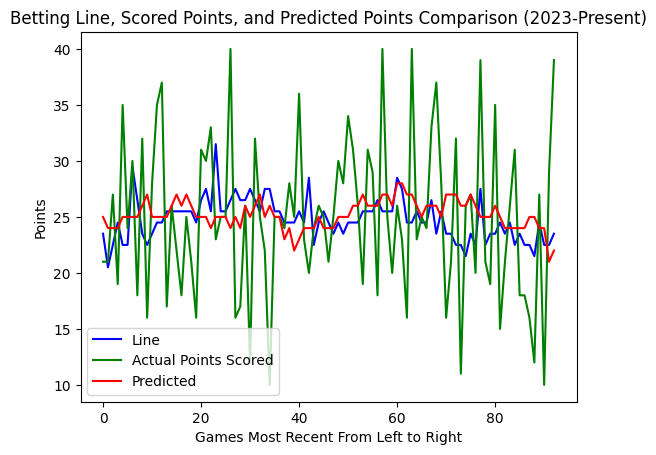

In [184]:
plt.plot(df_betting['Line'], label='Line', color='blue')
plt.plot(df_betting['PTS'], label='Actual Points Scored', color='green')
plt.plot(df_betting['Predicted'], label='Predicted', color='red')

plt.title("Betting Line, Scored Points, and Predicted Points Comparison (2023-Present)")
plt.xlabel("Games Most Recent From Left to Right")
plt.ylabel("Points")
plt.legend()

plt.show()

# Betting in Different Ways

We will bet on points scored by LeBron James in several different ways and see if one approach works better than others. For this, we will bet **\$100 on the favorite** regardless of which side is the favorite.

### How Betting Works:
- If one side is **negative** (e.g., **-120**), this means it requires **\$120** to make a net profit of **\$100** (resulting in a total return of \$220). Betting **\$100** is proportional to the gains that would have been won if we bet the amount needed to win \$100.  
   - The side that is **more negative** or **lower** is considered the **favorite**.

- If one side is **positive** (e.g., **+120**), this means it requires **\$100** to make a net profit of **\$120**.  
   - The side that is **higher** is not considered the **favorite**.


## Baseline: Bet the Favorite Every Game
If one simply bet on the favorite using the FanDuel sports book for every game that LeBron James has played given our available data from 2023 to the present, how would they have fared so far?

In [185]:
def calculate_profit(df, method=None):
    def trend_pick(cur, prev=None, prev_prev=None):
        if prev_prev is None and prev:
            if cur < prev:
                return "Under"
            else:
                return "Over"
        else:
            if prev > cur and prev_prev > prev:
                return "Under"
            elif prev < cur and prev < prev_prev:
                return "Over"
            elif prev > cur and prev_prev < prev:
                return "Under"
            else:
                return "Over"
            
    spendings, winnings, correct = 0, 0, 0
    df['Spendings'] = 0
    df['Winnings'] = 0
    df['Profit'] = 0
    for index, game_details in df.iterrows():
        spendings += 100
        
        if method is None:
            betting_pick = "Over" if game_details['Over'] < game_details['Under'] else "Under"
        elif method == "Prediction":
            betting_pick = "Over" if game_details['Predicted'] > game_details['Line'] else "Under"
        elif method == "Trend":
            current_game_prediction = df.at[index, "Predicted"]
            if index == 0:
                betting_pick = "Over" if game_details['Over'] < game_details['Under'] else "Under"
            elif index == 1:
                prev_game_prediction = df.at[index - 1, "Predicted"]
                betting_pick = trend_pick(current_game_prediction, prev_game_prediction, prev_prev=None)
            else:
                prev_game_prediction = df.at[index - 1, "Predicted"]
                prev_prev_game_prediction = df.at[index - 2, "Predicted"]
                betting_pick = trend_pick(current_game_prediction, prev_game_prediction, prev_prev=prev_prev_game_prediction)
                
        result = "Over" if game_details['PTS'] > game_details['Line'] else "Under"
        if betting_pick == result:
            wage = game_details[betting_pick]
            if wage < 0:
                winnings += abs((100 / wage) * 100) + 100
            else:
                winnings += wage + 100
            correct += 1
        df.at[index, 'Spendings'] = np.round(spendings, 2)
        df.at[index, 'Winnings'] = np.round(winnings, 2)
        df.at[index, 'Profit'] = np.round(winnings - spendings, 2)

    net_profit = winnings - spendings
    profit_per_game = round(net_profit / len(df), 2)

    df = df.drop(columns=['Day', 'Month', 'Year'])

    print(f"We bet ${spendings} to earn ${winnings:.2f} for a net profit of ${net_profit:.2f} "
          f"or ${profit_per_game} per game from 2023 to the present.\n")
    
    
    return df, np.round(correct/len(df)*100, 2)

In [186]:
df_baseline, baseline_correct = calculate_profit(df_betting.copy())
df_baseline = df_baseline.drop(columns=["Predicted"])

print(f"Betting the favorite every game is only correct about {baseline_correct}% of the tinme")
df_baseline

We bet $9300 to earn $7817.79 for a net profit of $-1482.21 or $-15.94 per game from 2023 to the present.

Betting the favorite every game is only correct about 45.16% of the tinme


,PTS,Line,Over,Under,Spendings,Winnings,Profit
0,21.0,23.5,-120.0,-102.0,100,0.00,-100.00
1,21.0,20.5,-118.0,-104.0,200,184.75,-15.25
2,27.0,22.5,-100.0,-122.0,300,184.75,-115.25
3,19.0,24.5,-122.0,-104.0,400,184.75,-215.25
4,35.0,22.5,-104.0,-118.0,500,184.75,-315.25
...,...,...,...,...,...,...,...
88,12.0,21.5,-110.0,-110.0,8900,7450.38,-1449.62
89,27.0,24.5,-112.0,-108.0,9000,7639.67,-1360.33
90,10.0,22.5,104.0,-128.0,9100,7817.79,-1282.21
91,29.0,22.5,-102.0,-120.0,9200,7817.79,-1382.21


Evidently, a person that bet on the favorite every game lost money.

## Method 1: Predicted vs. Betting Line

Let's now use our LSTM model and see how much we would profit if we took the predicted points scored per game at face value when compared to the line from FanDuel

In [187]:
df_predicted, prediction_correct = calculate_profit(df_betting.copy(), method="Prediction")

print(f"Betting with our LSTM model is only correct about {prediction_correct}% of the tinme")
df_predicted

We bet $9300 to earn $9437.05 for a net profit of $137.05 or $1.47 per game from 2023 to the present.

Betting with our LSTM model is only correct about 52.69% of the tinme


,PTS,Line,Over,Under,Predicted,Spendings,Winnings,Profit
0,21.0,23.5,-120.0,-102.0,25,100,0.00,-100.00
1,21.0,20.5,-118.0,-104.0,24,200,184.75,-15.25
2,27.0,22.5,-100.0,-122.0,24,300,384.75,84.75
3,19.0,24.5,-122.0,-104.0,24,400,580.90,180.90
4,35.0,22.5,-104.0,-118.0,25,500,777.05,277.05
...,...,...,...,...,...,...,...,...
88,12.0,21.5,-110.0,-110.0,25,8900,9437.05,537.05
89,27.0,24.5,-112.0,-108.0,24,9000,9437.05,437.05
90,10.0,22.5,104.0,-128.0,24,9100,9437.05,337.05
91,29.0,22.5,-102.0,-120.0,21,9200,9437.05,237.05


## Method 2: Predicted Trends vs. Betting Line

Let's now use our LSTM model and see how much we would profit if, instead of taking the points scored at face value, we also took into consideration the direction (i.e., trend) of LeBron James' scoring.

Our algorithm considers up to **three adjacent predictions** if available. Specifically, we analyze the current game's prediction (`cur`), the previous game's prediction (`prev`), and two games prior (`prev_prev`) to make a decision on whether to pick the **Over** or **Under** on the prop line.

---

### Over/Under Decision Logic

The decision is based on the relative values of `cur` (current prediction), `prev` (previous prediction), and `prev_prev` (two games prior). Here's the logic:

1. **If `prev_prev` is `None` and `prev` exists** (i.e., the second prediction in a series):  
   - This means there is no value two games prior to compare, but there is a previous prediction.  
   - If `cur` (current prediction) is **less than** `prev` (previous prediction), return `"Under"`.  
   - Otherwise, return `"Over"`.

2. **If `prev_prev` and `prev` both exist** (i.e., at least three predictions are available):  
   - **If `prev > cur` and `prev_prev > prev`** (decreasing trend): Return `"Under"`.  
   - **If `prev < cur` and `prev < prev_prev`** (increasing trend): Return `"Over"`.  
   - **If `prev > cur` and `prev_prev < prev`** (a dip in the middle): Return `"Under"`.  
   - **In all other cases** (e.g., mixed or unclear trend): Return `"Over"`.  

In [188]:
df_trend, trend_correct = calculate_profit(df_betting.copy(), method="Trend")

print(f"Betting with our LSTM model is only correct about {trend_correct}% of the tinme")
df_trend

We bet $9300 to earn $9400.82 for a net profit of $100.82 or $1.08 per game from 2023 to the present.

Betting with our LSTM model is only correct about 52.69% of the tinme


,PTS,Line,Over,Under,Predicted,Spendings,Winnings,Profit
0,21.0,23.5,-120.0,-102.0,25,100,0.00,-100.00
1,21.0,20.5,-118.0,-104.0,24,200,0.00,-200.00
2,27.0,22.5,-100.0,-122.0,24,300,200.00,-100.00
3,19.0,24.5,-122.0,-104.0,24,400,200.00,-200.00
4,35.0,22.5,-104.0,-118.0,25,500,396.15,-103.85
...,...,...,...,...,...,...,...,...
88,12.0,21.5,-110.0,-110.0,25,8900,8820.90,-79.10
89,27.0,24.5,-112.0,-108.0,24,9000,9010.18,10.18
90,10.0,22.5,104.0,-128.0,24,9100,9010.18,-89.82
91,29.0,22.5,-102.0,-120.0,21,9200,9208.22,8.22


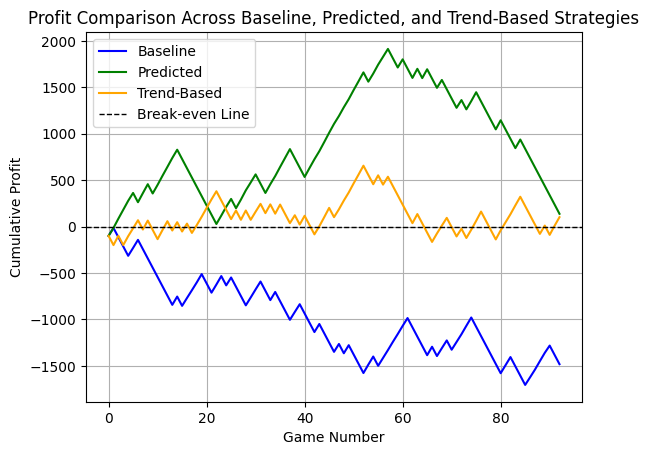

In [189]:
plt.plot(df_baseline.index, df_baseline['Profit'], label='Baseline', color='blue')
plt.plot(df_predicted.index, df_predicted['Profit'], label='Predicted', color='green')
plt.plot(df_trend.index, df_trend['Profit'], label='Trend-Based', color='orange')

plt.title("Profit Comparison Across Baseline, Predicted, and Trend-Based Strategies")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Break-even Line')
plt.xlabel("Game Number")
plt.ylabel("Cumulative Profit")
plt.legend()
plt.grid(True)

plt.show()